In [ ]:
library('caret')
library('gbm')

# library('DESeq2')
library('tidyverse')
# library('EnhancedVolcano')
# library('org.Hs.eg.db')
# library('clusterProfiler')
# library('ggplot2')
# library('gplots')

Loading required package: lattice

Loading required package: ggplot2

Loaded gbm 2.1.8

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::lift()   masks caret::lift()



In [ ]:
x_train = read.delim('Train_call.txt', header = TRUE, sep = "\t", quote = "\"", dec = ".", fill = TRUE, comment.char = "")
y_train = read.delim('Train_clinical.txt', header = TRUE, sep = "\t", quote = "\"", dec = ".", fill = TRUE, comment.char = "", row.names = 1)

x_train = t(x_train)


In [ ]:
data <- merge(y_train, x_train[5:nrow(x_train),], by = 'row.names')
row.names(data) <- data$Row.names
data$Row.names <- NULL
head(data)

,Subgroup,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V2825,V2826,V2827,V2828,V2829,V2830,V2831,V2832,V2833,V2834
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Array.10,HER2+,0,0,0,0,0,0,0,0,0,⋯,1,1,0,1,1,1,1,1,1,1
Array.100,HR+,0,0,0,0,0,0,0,0,0,⋯,1,1,1,1,1,1,1,1,1,1
Array.101,HR+,0,0,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
Array.102,Triple Neg,0,0,0,0,-1,-1,-1,0,-1,⋯,1,1,1,1,1,1,1,1,1,1
Array.104,Triple Neg,0,0,0,0,0,0,0,0,0,⋯,1,1,1,1,1,1,1,1,1,1
Array.105,HER2+,0,0,0,0,0,0,0,0,-1,⋯,2,1,1,1,1,1,1,2,2,2


In [ ]:
set.seed(123)
overall_accuracies = NULL
# outer loop x100
for (j in seq(1,100)) {
  start_time <- Sys.time()
  # ---------------------------------------------------------------------------------------
  msk <- createDataPartition(data[,'Subgroup'], p = 0.8, list = FALSE, times = 1)
  # split the data into training and test set
  dataTrain  <- data[msk, ] # 81 instances
  dataTest <- data[-msk, ]  # 19 instances
  
  rocVarImp <- filterVarImp(dataTrain[, -which(names(dataTrain) == "Subgroup")],
                            factor(dataTrain[, 'Subgroup']) , nonpara = FALSE)
  
  rocVarImpSum <- apply(rocVarImp, 1, sum)
  rocVarImpSum_sorted <- sort(rocVarImpSum, decreasing = TRUE)
  sorted_idx <- strtoi(substring(names(rocVarImpSum_sorted), 2))
  sorted_idx <- paste0('V', sorted_idx)
  write.csv(sorted_idx, file = paste0("knn2_splits/features_split", j, ".csv"))
  
  # ---------------------------------------------------------------------------------------
  # Set up Repeated k-fold Cross Validation
  train_control <- trainControl(method="repeatedcv",
                                number=10,
                                repeats=3,
                                search = "random")
  #methods <- c('rpart')
  #i = 0
  res = NULL # stores results of all models of this split

  tune_grid <- expand.grid(k = 1:10) ## train models for k = 1:10 nearest neighbours
  # add features 
  for (n in seq(1, nrow(dataTrain)+20, 1)) {
    temp_data <- dataTrain[,c('Subgroup', sorted_idx[1:n])] # first n features are used for training
    model <- train(Subgroup ~., data = temp_data, method = "knn", trControl = train_control, tuneGrid = tune_grid)
    res = bind_rows(res, as_tibble(c(model$results[which.max(model$results[,'Accuracy']),], list(split = j, predictors = n, method = 'knn'))))
    #for (method in methods) {
      #i = i + 1
      #tree <- train(Subgroup ~., data = temp_data, method = method, trControl = train_control, tuneLength = 10)
      #res = bind_rows(res, as_tibble(c(tree$results[which.max(tree$results[,'Accuracy']),], list(split = j, predictors = n, method = 'knn'))))
    #}
  }

  write.csv(res , file = paste0("knn2_splits/results_training_s1_split", j, ".csv"))
  # ---------------------------------------------------------------------------------------
  
  #     res <- read.csv('results_training_s1.csv')
  optimal_params <- as.data.frame(res[which.max(as.numeric(unlist(res['Accuracy']))), c('k', 'predictors', 'method')])
  print(optimal_params)
  # predictors = features

  train_control <- trainControl(method="none")
  tuneGrid = expand.grid(k = optimal_params$k)
  
  
  temp_data <- dataTrain[,c('Subgroup', sorted_idx[1:optimal_params[,'predictors']])]
  model2 <- train(Subgroup ~., data = temp_data, method = optimal_params$method, trControl = train_control, 
               tuneGrid = tuneGrid)
  print(model2)
  
  y_pred = predict(model2, newdata = dataTest[,sorted_idx[1:optimal_params[,'predictors']]])
  
  overall_accuracies = c(overall_accuracies, 
                         confusionMatrix(data = y_pred, as.factor(dataTest[, 'Subgroup']))$overall[['Accuracy']])
  
  ggplot() + 
    geom_line(data = res, aes(x = predictors, y = Accuracy, group = method, color=method)) +
    ylab(label="Accuracy") +
    xlab("Predictors") + 
    ggtitle("Optimized models using random grid search and 10-fold CV\nfor different number of significant predictors in descending order.") + 
    labs(color="Methods")
  ggsave(paste0("knn2_splits/training_s1_split", j, ".png"))
  end_time <- Sys.time()
  print(end_time - start_time)
  print(paste0('Split ', j , ' done.'))
}


Resampling: None 
Saving 6.67 x 6.67 in image

Time difference of 2.228129 mins
[1] "Split 29 done."
  k predictors method
1 3         40    knn
k-Nearest Neighbors 

81 samples
40 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 
Saving 6.67 x 6.67 in image

Time difference of 2.221733 mins
[1] "Split 30 done."
  k predictors method
1 1         30    knn
k-Nearest Neighbors 

81 samples
30 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 
Saving 6.67 x 6.67 in image

Time difference of 2.226872 mins
[1] "Split 31 done."
  k predictors method
1 4         73    knn
k-Nearest Neighbors 

81 samples
73 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 
Saving 6.67 x 6.67 in image

Time difference of 2.229946 mins
[1] "Split 32 done."
  k predictors method
1 5         22    knn
k-Nearest Neighbors 

81 samples
22 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre

[1] 0.6605263

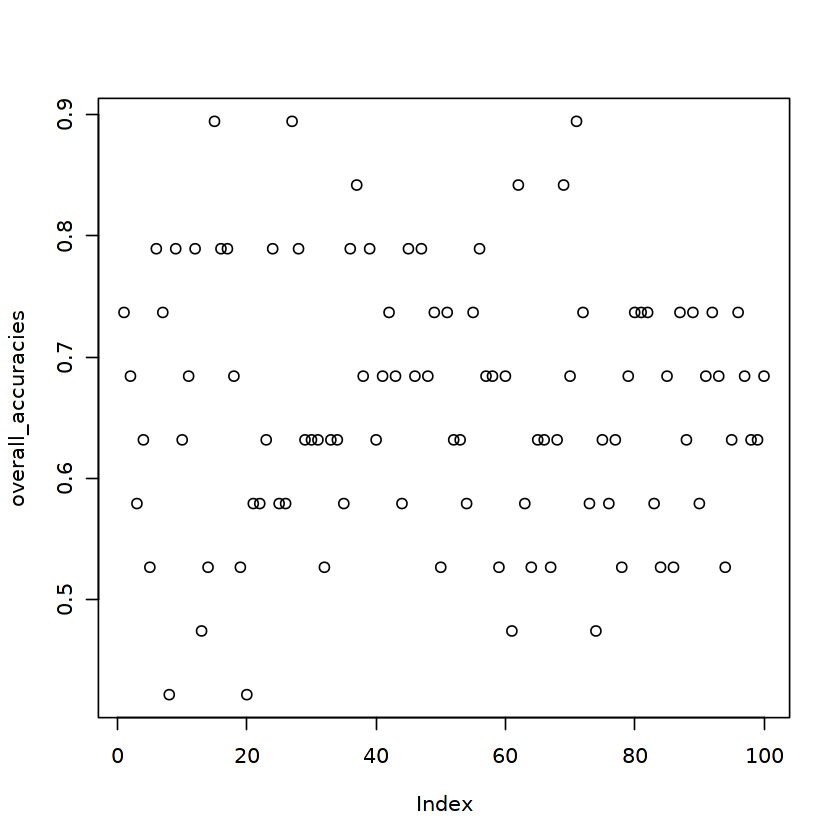

In [ ]:
# plot accuracy in plot 
mean(overall_accuracies)
plot(overall_accuracies)

In [ ]:
#save overall accuracy
write.csv(overall_accuracies , file = "knn2_splits/overall_accuracies.csv")

In [ ]:
accuracy <- read.csv("knn2_splits/overall_accuracies.csv")
head(accuracy)


,X,x
,<int>,<dbl>
1,1,0.7368421
2,2,0.6842105
3,3,0.5789474
4,4,0.6315789
5,5,0.5263158
6,6,0.7894737


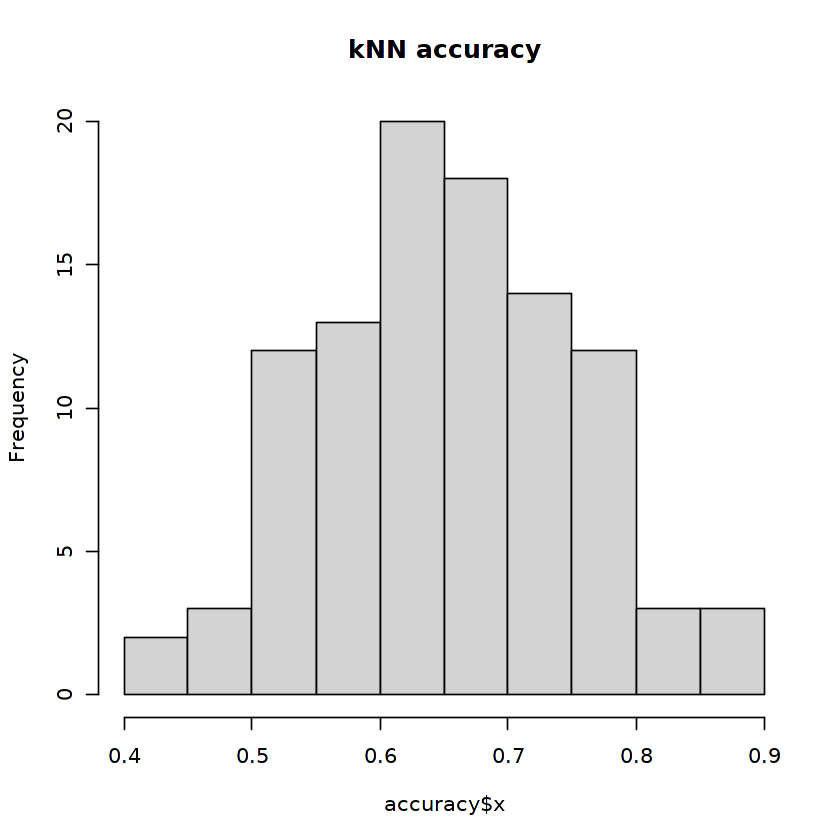

In [ ]:
hist(accuracy$x, main='kNN accuracy')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e50088cd-08d8-40b0-8c1b-e1fc7b675864' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>